In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
import preprocess
from IPython import display


In [2]:
def dcg_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(10*10*64, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((10, 10, 64)))
#     assert model.output_shape == (None, 45, 45, 64) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 45, 45, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 45, 45, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 90,90, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 160, 160, 3)

    return model

def dcg_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[160, 160, 3]))
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [3]:
def main():
    
    return
if __name__ == '__main__':
    main()

In [4]:
images = preprocess.load_images("/git-repos/latent-space-arithmetic/dataset/")

Found 202599 files belonging to 4 classes.


In [5]:
generator = dcg_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = dcg_discriminator_model()
decision = discriminator(generated_image)


In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [7]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 32
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [8]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [9]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        t=0
        for image_batch, label_batch in dataset:
            t+=1
            train_step((image_batch-127.5)/127.5)
#             print((time.time()-start)/t)
            if t==500: break

        # Produce images for the GIF as we go
    #     display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
#         if (epoch + 1) % 15 == 0:
#             checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    #     display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed)

In [10]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :]/2+0.5 )
        plt.axis('off')

#     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

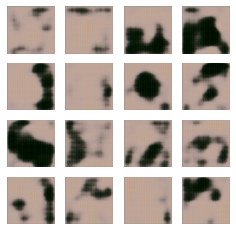

Time for epoch 1 is 54.46740937232971 sec


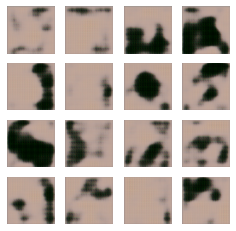

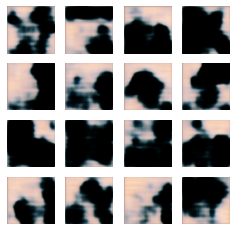

Time for epoch 2 is 52.948476791381836 sec


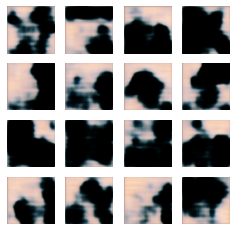

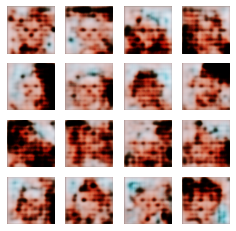

Time for epoch 3 is 52.04573965072632 sec


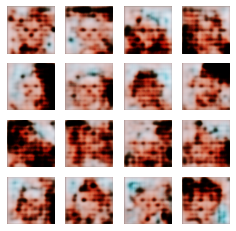

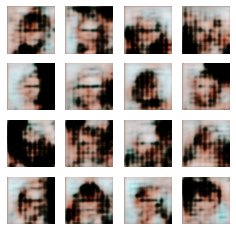

Time for epoch 4 is 47.89689588546753 sec


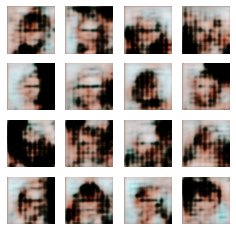

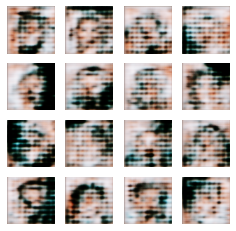

Time for epoch 5 is 50.309099197387695 sec


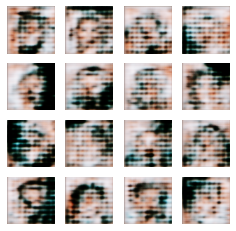

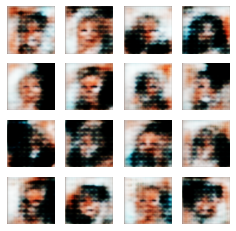

Time for epoch 6 is 47.992515087127686 sec


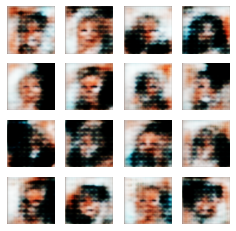

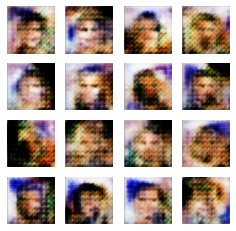

Time for epoch 7 is 48.11834502220154 sec


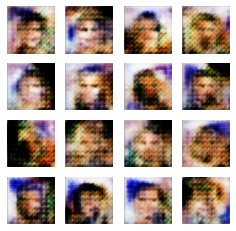

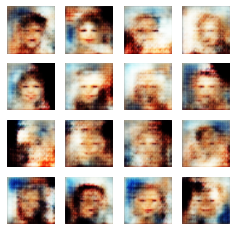

Time for epoch 8 is 49.36592960357666 sec


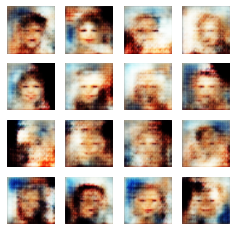

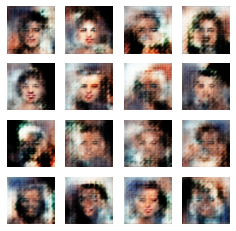

Time for epoch 9 is 49.44476318359375 sec


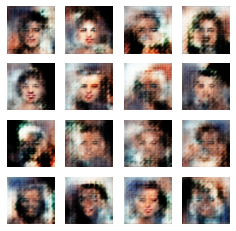

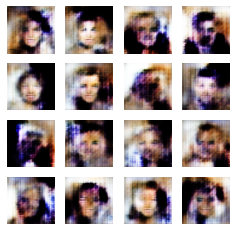

Time for epoch 10 is 49.42343258857727 sec


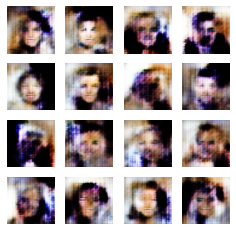

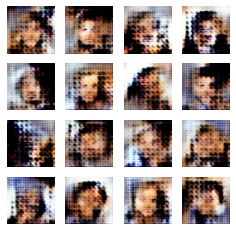

Time for epoch 11 is 56.639972448349 sec


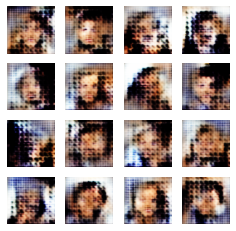

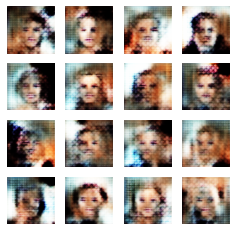

Time for epoch 12 is 55.298656702041626 sec


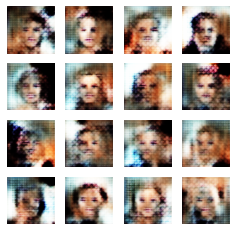

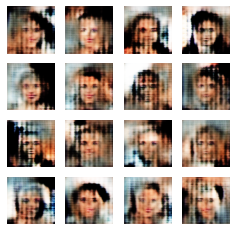

Time for epoch 13 is 60.12795567512512 sec


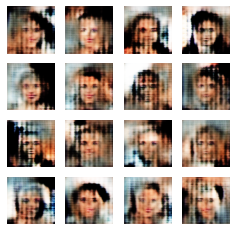

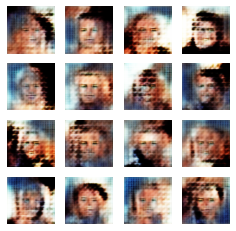

Time for epoch 14 is 55.07065486907959 sec


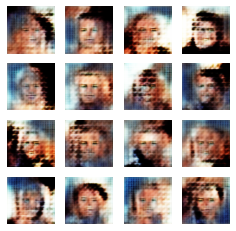

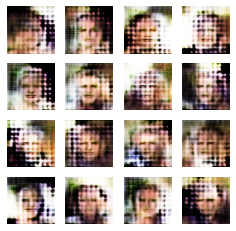

Time for epoch 15 is 53.69873642921448 sec


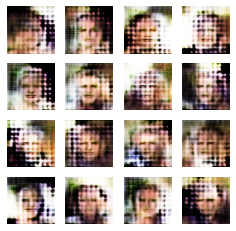

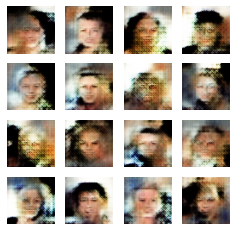

Time for epoch 16 is 50.90233278274536 sec


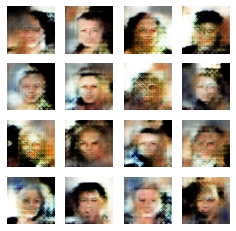

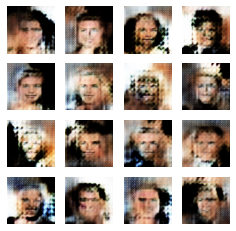

Time for epoch 17 is 57.942150592803955 sec


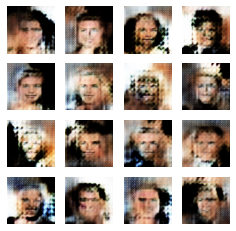

KeyboardInterrupt: 

In [11]:
train(images, EPOCHS)

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [ ]:
plt.imshow(generated_image[0, :, :, :], cmap='viridis')